# Two-dimensional objects
So far, all the notebooks showed how to apply the Sequencer to datasets consisting of one-dimensional objects. The Sequencer can also be applied to datasets consisting of two-dimensional objects, such as images. This notebook loads a dataset consisting of a set of images that form a clear sequence, shuffles the relative order of the images, and then applies the Sequencer to the shuffled dataset. <br>
Then, I show an example of a Sequencer run with non-default set of scales.  

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [1]:
#!conda install numpy scipy networkx matplotlib
#!pip install imageio
#!pip install TheSequencer

In [2]:
# imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
import imageio

#import sequencer
import sys
sys.path.append("/Users/dalyabaron/Documents/EMD/Sequencer/")
import sequencer

## Load the dataset
I will start by loading the dataset, which consists of images showing a rotating Jupiter. I will plot the different images in their correct order, and then will produce the final dataset by shuffling the images. 

In [3]:
gif_path = "data_for_examples/two_dimensional_datasets/jupiter-planet-animation-4.gif"
f = imageio.mimread(gif_path)
print("number of images in the gif file: ", len(f))
print("the shape of each image in the gif file: ", f[0].shape)

number of images in the gif file:  28
the shape of each image in the gif file:  (92, 92, 4)


flatten the images to be intensity only - I will do that using an average

In [4]:
label_list = []
image_list = []

for i, image in enumerate(f):
    label_list.append(i)
    image_list.append(numpy.average(image, axis=-1))
    
label_list = numpy.array(label_list)
image_list = numpy.array(image_list)

print("length of dataset: ", len(image_list))

length of dataset:  28


visualize one image from the dataset

([], <a list of 0 Text yticklabel objects>)

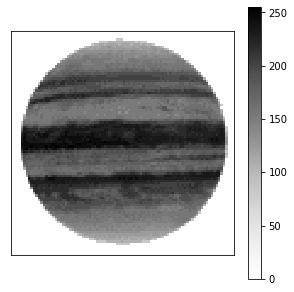

In [5]:
image_tmp = image_list[14]
plt.figure(1, figsize=(5, 5))
plt.imshow(image_tmp, cmap="Greys")
plt.colorbar()
plt.xticks([])
plt.yticks([])

Add a constant of 1 to every pixel, so that the minimal value will be 1 and not 0. This is necessary if we want to use the KL metric with the Sequencer later on. 

([], <a list of 0 Text yticklabel objects>)

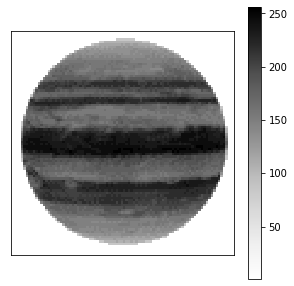

In [6]:
image_list_pos = 1 + numpy.array(image_list)

image_tmp = image_list_pos[5]
plt.figure(1, figsize=(5, 5))
plt.imshow(image_tmp, cmap="Greys")
plt.colorbar()
plt.xticks([])
plt.yticks([])

In [7]:
print(numpy.min(image_list_pos), numpy.max(image_list_pos))

1.0 256.0


Visualize the entire dataset by plotting every frame, according to their order of appearance in the gif:

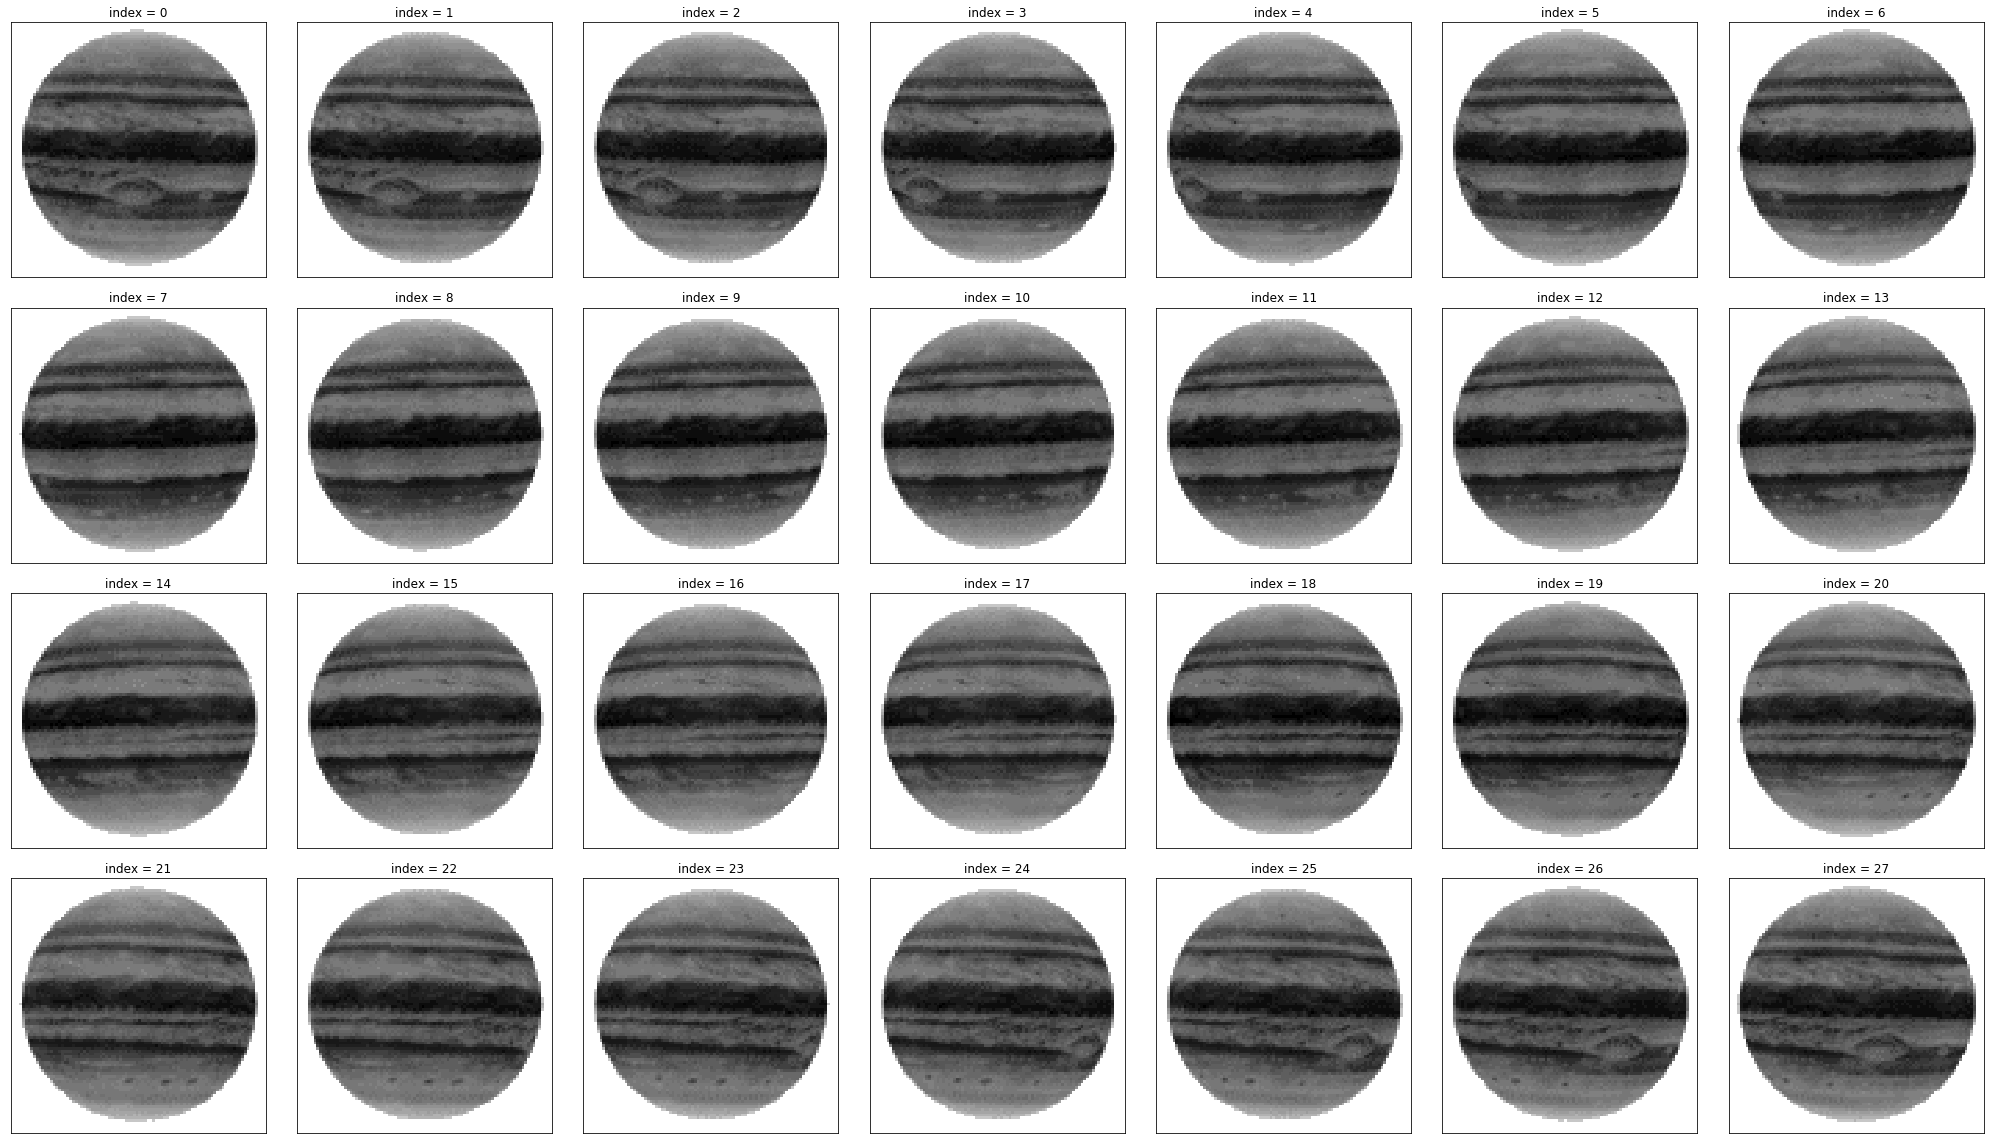

In [9]:
plt.figure(1, figsize=(4*7, 4*4))

for i in range(len(image_list_pos)):
    image = image_list_pos[i]
    plt.subplot(4, 7, i + 1)
    plt.title("index = %s" % i)
    plt.imshow(image, cmap="Greys")
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

Shuffle the relative order of the different images to produce the final dataset which will serve as the input to the Sequencer:

In [10]:
# shuffle the label list, and using this, the image list:
numpy.random.shuffle(label_list)
my_dataset_shuffled = image_list_pos[label_list, :, :]
print(my_dataset_shuffled.shape)

# create a grid, which you will need for the Sequencer
# since we will be using KL and L2, which do not care about the coordinates, this array is arbitrary
grid = numpy.reshape(numpy.arange(92 * 92), (92, 92))
print(grid.shape)

(28, 92, 92)
(92, 92)


## Apply the Sequencer to this dataset
I will now apply the Sequencer to the shuffled image list. The default setting of the Sequencer for two-dimensional datasets is to use the full image, i.e., scale=(1,1) for each estimator. <br> 
Later in this notebook, I will show how to split the images to chunks by setting a different list of scales.

In [11]:
# define the list of distance metrics to consider.
# I include only KL and L2, because EMD and energy distance are not defined for 2D objects
estimator_list = ['KL', 'L2']

# define the sequencer object with default parameters
seq = sequencer.Sequencer(grid, my_dataset_shuffled, estimator_list)

# to execute the sequencer, we first need to define the output directory to which the different 
# outputs will be saved
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: KL, scale: (1, 1)
finished calculating this distance matrix list, it took: 0.2117319107055664 seconds
calculating the distance matrices for estimator: L2, scale: (1, 1)
finished calculating this distance matrix list, it took: 0.017812252044677734 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: KL, scale: (1, 1)
in estimator: L2, scale: (1, 1)
dumped the elongations to the file: sequencer_output_directory/elongations.pkl
dumped the full weighted distance matrix to the file: sequencer_output_directory/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>


/Users/dalyabaron/Documents/EMD/Sequencer/sequencer/sequencer_.py:945: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


In [12]:
# print the final elongation
print("resulting elongation: ", final_elongation)

# print the elongations for the different scales and metrics:
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

resulting elongation:  16.857142857142858
metric=KL, scale=(1, 1), elongation: 9.915816326530612
metric=L2, scale=(1, 1), elongation: 16.857142857142858


Plot the indices of the ordered array versus the original indices of the images, from ```labal_list```:

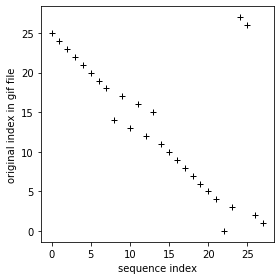

In [13]:
label_list_reordered = label_list[final_sequence]

plt.figure(1, figsize=(4, 4))
plt.plot(label_list_reordered, "+k")
plt.xlabel("sequence index")
plt.ylabel("original index in gif file")
plt.tight_layout()

Produce a plot showing the ordered dataset:

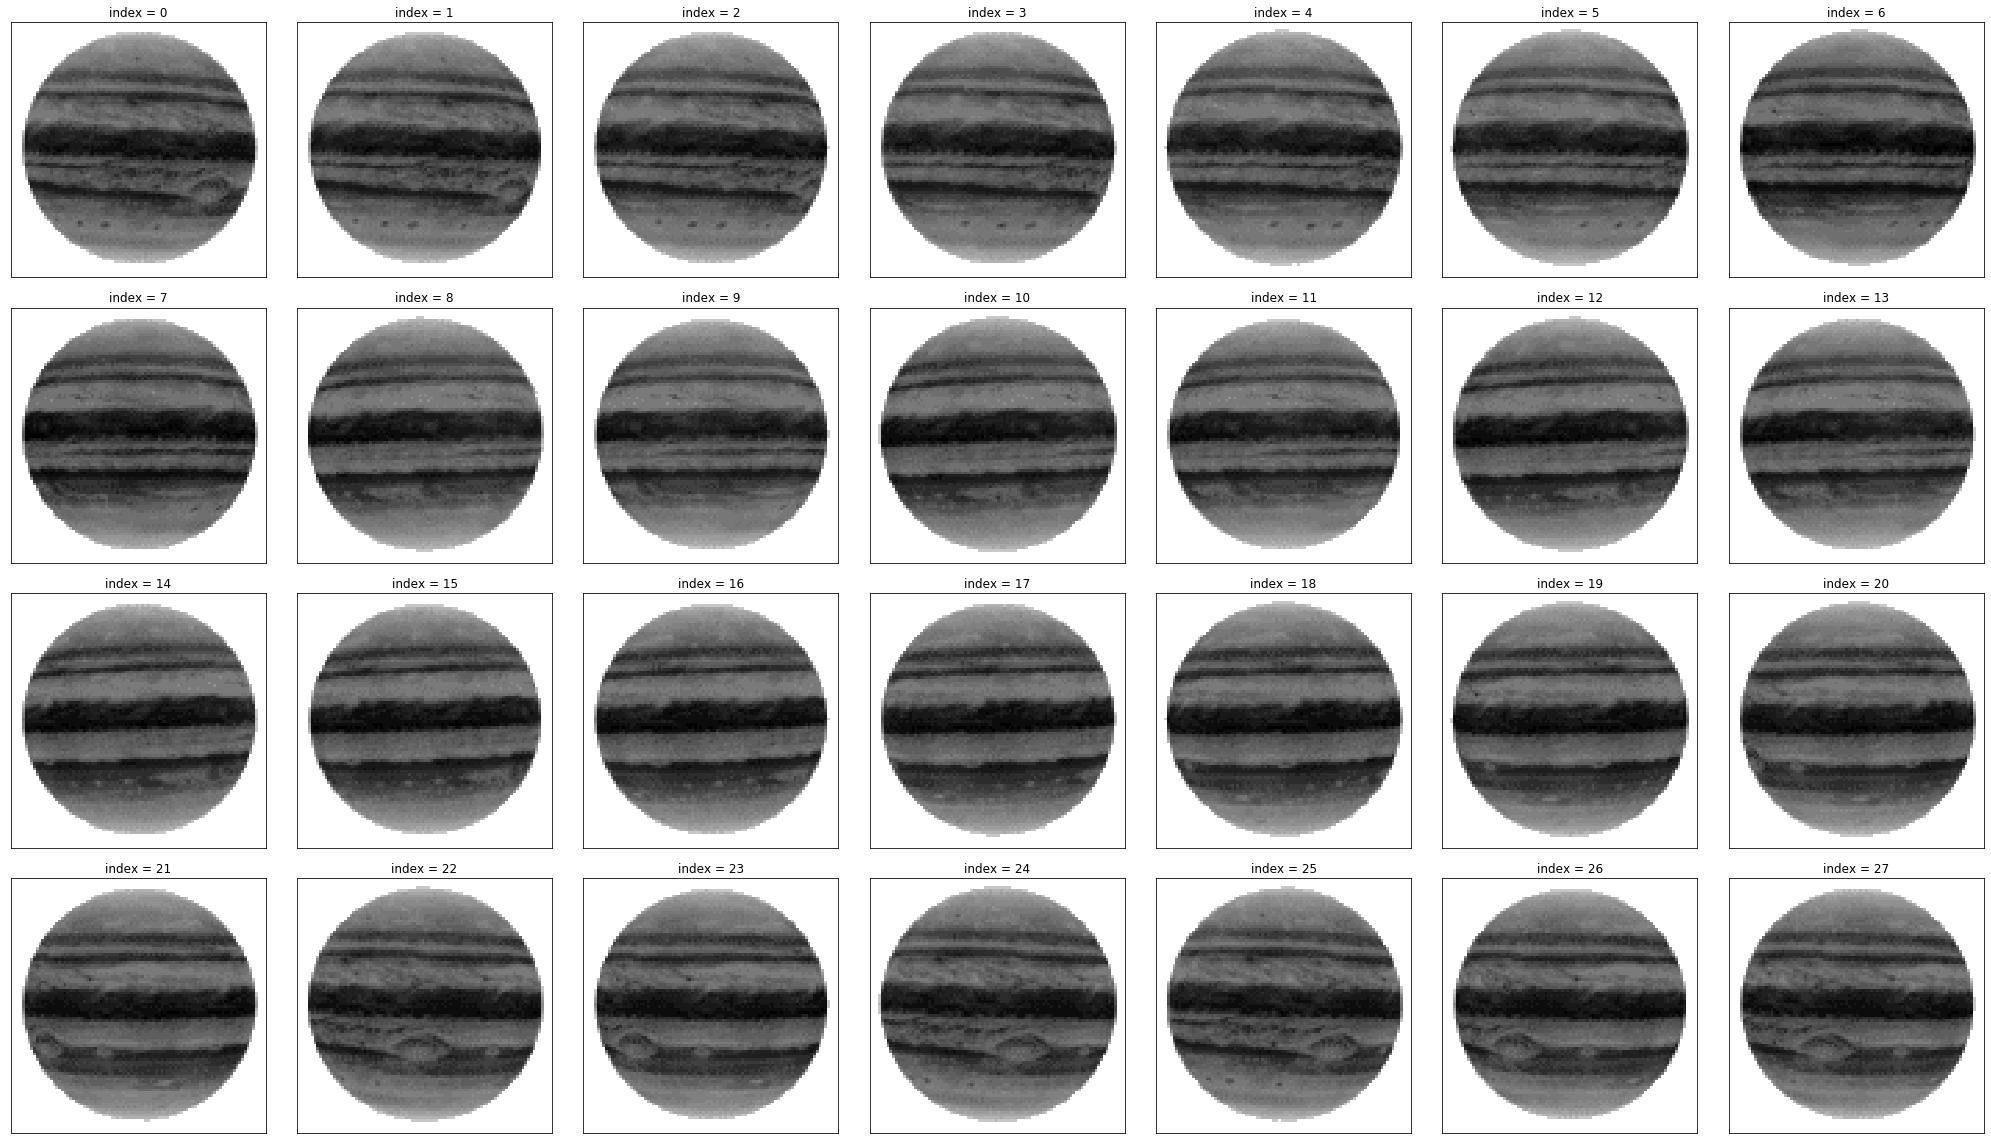

In [15]:
image_list_ordered = my_dataset_shuffled[final_sequence, :]

plt.figure(1, figsize=(4*7, 4*4))

for i in range(len(image_list_ordered)):
    image = image_list_ordered[i]
    plt.subplot(4, 7, i + 1)
    plt.title("index = %s" % i)
    plt.imshow(image, cmap="Greys")
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

## Non-default set of scales
I will now apply the Sequencer to the same shuffled dataset, but will select a non-default set of scales. When applying the Sequencer to one-dimensional datasets, the set of scales was a list of integers, describing the number of chunks to which every object will be divided. <br>
With two-dimensional objects, we can split them in the horizontal and vertical directions, so a set of scales will be represented by a list, where each element of the list will be a tuple. Each tuple will be of the form `(scale_x, scale_y)`, where `scale_x` represents the number of horizontal chunks, and `scale_y` represents the number of vertical chunks. <br>
For example, for a single metric, a list of scales can look like this: `scale_list = [[(1, 1), (1, 2), (2, 2), (2, 2)]]`. This means that the Sequencer will consider the following:
- `(1,1)`: The Sequencer considers the full images and does not split them into chunks.
- `(1,2)`: The Sequencer splits the images into two parts in the vertical direction. 
- `(2,1)`: The Sequencer splits the images into two parts in the horizontal direction.
- `(2,2)`: The Sequencer splits the images into two parts in the horizontal and vertical direction. This results in four parts.

Important note: we should be careful not to divide the images into too small parts. If the images contain a lot of white background (pixels which equal zero), then we could result in chunks which are zeros in all pixels. In such a case, we cannot use the EMD, energy, or KL metrics. In such cases, it might be best to add a small offest to all the pixels in the image, like the offset of 1 we added to the Jupyter image.

In [16]:
# define the list of distance metrics to consider.
# I include only KL and L2, because EMD and energy distance are not defined for 2D objects
estimator_list = ['KL', 'L2']
scale_list = [[(1, 1), (1, 2), (2, 1), (2, 2)],
              [(1, 1), (1, 2), (2, 1), (2, 2)]]

# define the sequencer object with default parameters
seq = sequencer.Sequencer(grid, my_dataset_shuffled, estimator_list, scale_list)

# to execute the sequencer, we first need to define the output directory to which the different 
# outputs will be saved
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: KL, scale: (1, 1)
finished calculating this distance matrix list, it took: 0.15673613548278809 seconds
calculating the distance matrices for estimator: KL, scale: (1, 2)
finished calculating this distance matrix list, it took: 0.15217304229736328 seconds
calculating the distance matrices for estimator: KL, scale: (2, 1)
finished calculating this distance matrix list, it took: 0.15277981758117676 seconds
calculating the distance matrices for estimator: KL, scale: (2, 2)
finished calculating this distance matrix list, it took: 0.20395302772521973 seconds
calculating the distance matrices for estimator: L2, scale: (1, 1)
finished calculating this distance matrix list, it took: 0.009207963943481445 seconds
calculating the distance matrices for estimator: L2, scale: (1, 2)
finished calculating this distance matrix list, it took: 0.011543035507202148 seconds
calculating the distance matrices for estimator: L2, scale: (2, 1)
finished calculatin

In [19]:
# print the final elongation
print("resulting elongation: ", final_elongation)

# print the elongations for the different scales and metrics:
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

resulting elongation:  16.857142857142858
metric=KL, scale=(1, 1), elongation: 9.915816326530612
metric=KL, scale=(1, 2), elongation: 9.99234693877551
metric=KL, scale=(2, 1), elongation: 9.915816326530612
metric=KL, scale=(2, 2), elongation: 9.954081632653061
metric=L2, scale=(1, 1), elongation: 16.857142857142858
metric=L2, scale=(1, 2), elongation: 15.744897959183675
metric=L2, scale=(2, 1), elongation: 19.29591836734694
metric=L2, scale=(2, 2), elongation: 17.5


We can see that the Euclidean Distance + `scale=(2,1)` gives a larger elongation than the final elongation. Therefore, it will be interesting to consider the sequence that results from this scale alone. Therefore, we will now execute the Sequencer again, but will require the best estimator. 

In [22]:
# define the list of distance metrics to consider.
# I include only KL and L2, because EMD and energy distance are not defined for 2D objects
estimator_list = ['KL', 'L2']
scale_list = [[(1, 1), (1, 2), (2, 1), (2, 2)],
              [(1, 1), (1, 2), (2, 1), (2, 2)]]

# define the sequencer object with default parameters
seq = sequencer.Sequencer(grid, my_dataset_shuffled, estimator_list, scale_list)

# to execute the sequencer, we first need to define the output directory to which the different 
# outputs will be saved
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_average_N_best_estimators=True,
                                               number_of_best_estimators=1)

calculating the distance matrices for estimator: KL, scale: (1, 1)
finished calculating this distance matrix list, it took: 0.16434383392333984 seconds
calculating the distance matrices for estimator: KL, scale: (1, 2)
finished calculating this distance matrix list, it took: 0.16353678703308105 seconds
calculating the distance matrices for estimator: KL, scale: (2, 1)
finished calculating this distance matrix list, it took: 0.16200876235961914 seconds
calculating the distance matrices for estimator: KL, scale: (2, 2)
finished calculating this distance matrix list, it took: 0.2092139720916748 seconds
calculating the distance matrices for estimator: L2, scale: (1, 1)
finished calculating this distance matrix list, it took: 0.010874032974243164 seconds
calculating the distance matrices for estimator: L2, scale: (1, 2)
finished calculating this distance matrix list, it took: 0.01595592498779297 seconds
calculating the distance matrices for estimator: L2, scale: (2, 1)
finished calculating 

/Users/dalyabaron/Documents/EMD/Sequencer/sequencer/sequencer_.py:945: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


In [23]:
# print the final elongation
print("resulting elongation: ", final_elongation)

resulting elongation:  19.29591836734694


Plot the indices of the ordered array versus the original indices of the images, from ```labal_list```:

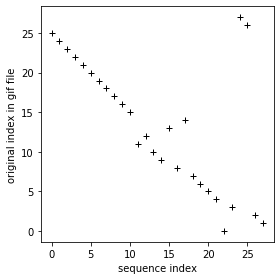

In [24]:
label_list_reordered = label_list[final_sequence]

plt.figure(1, figsize=(4, 4))
plt.plot(label_list_reordered, "+k")
plt.xlabel("sequence index")
plt.ylabel("original index in gif file")
plt.tight_layout()

and the ordered dataset:

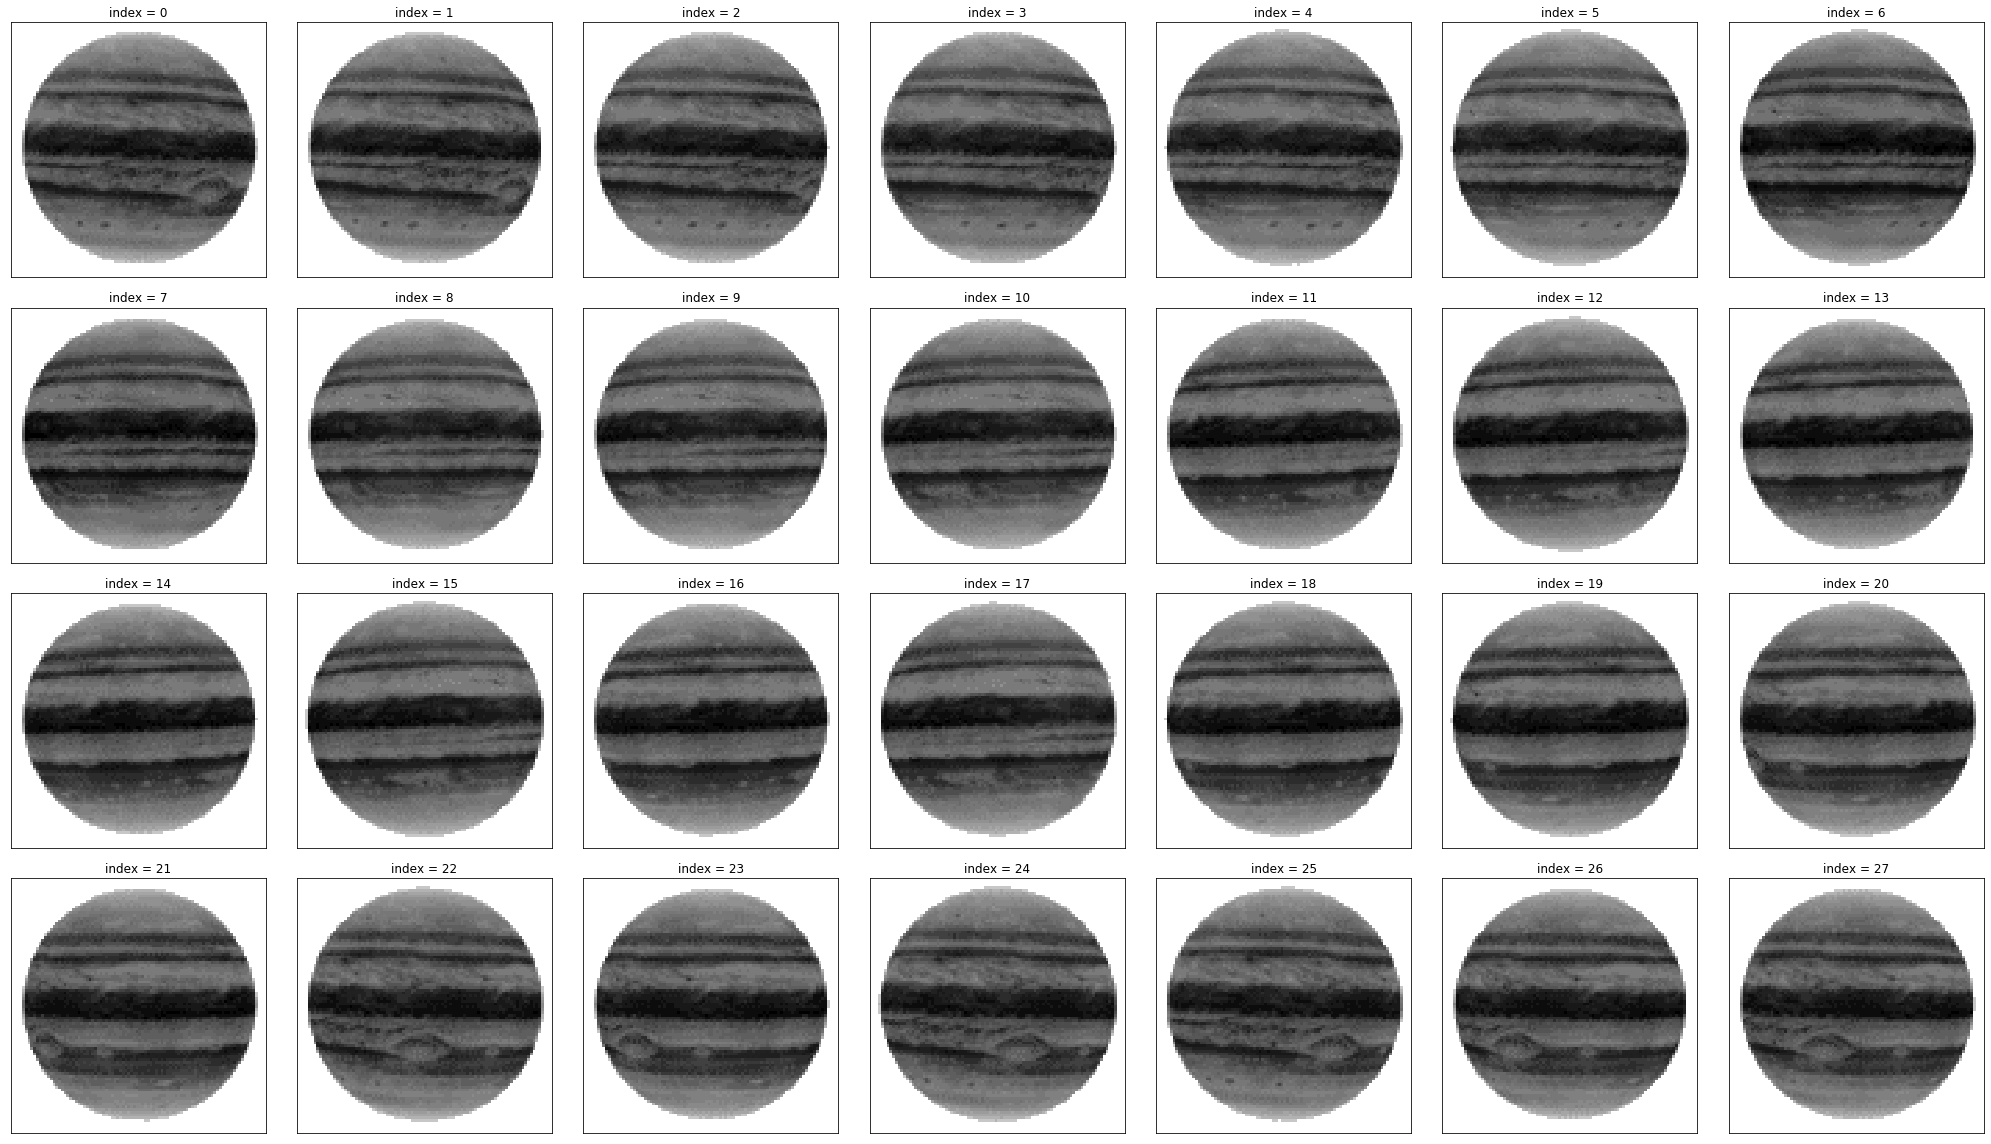

In [26]:
image_list_ordered = my_dataset_shuffled[final_sequence, :]

plt.figure(1, figsize=(4*7, 4*4))

for i in range(len(image_list_ordered)):
    image = image_list_ordered[i]
    plt.subplot(4, 7, i + 1)
    plt.title("index = %s" % i)
    plt.imshow(image, cmap="Greys")
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()